In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import simpy
import networkx as nx  
import numpy as np
import pandas as pd
import yaml as yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# OpenTNSim
from opentnsim import corelock5 as corelock
from opentnsim import plot
from opentnsim import model

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

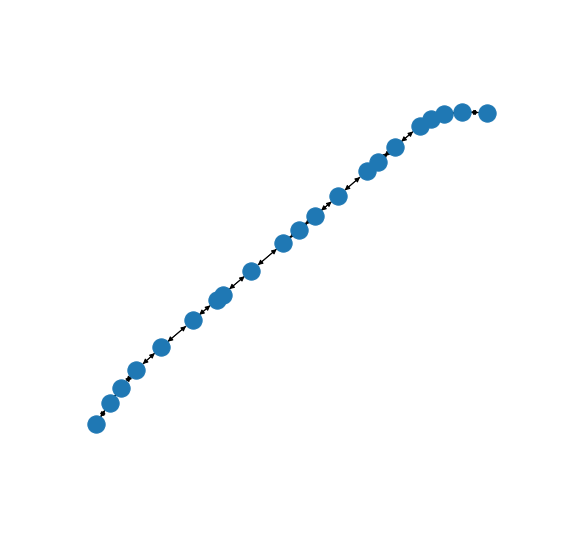

In [2]:
Node = type('Site', (corelock.Identifiable, corelock.Log, corelock.Locatable, corelock.HasResource), {})
nodes = []
path = []

coords = [[4.431711765453108,51.69919249464677],
          [4.428674043520671,51.69925058643445],
          [4.426520307378901,51.69909734687116],
          [4.424980827084277,51.69876203857485],
          [4.423697201845156,51.69822379606292],
          [4.42074464145006,51.69663454747826],
          [4.418738102576006,51.69556033504191],
          [4.417414946619205,51.69484342434918],
          [4.414052050039478,51.69302665557799],
          [4.411260559026335,51.69152063195392],
          [4.409375907761905,51.69049721074719],
          [4.407558470987929,51.68950444222966],
          [4.403773394426889,51.68748639488896],
          [4.400388700536705,51.68570503952014],
          [4.399705360113479,51.68532707785089],
          [4.396838866281541,51.68379266841475],
          [4.393109213885338,51.68180281425153],
          [4.390189828820366,51.68013249657422],
          [4.388336842048544,51.67879411774161],
          [4.387028491268927,51.6776897747193],
          [4.385381824047309,51.67609098108045]]

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes)-1):
            path.append([nodes[j], nodes[j+1]])
    if i == 1:
        for j in range(len(nodes)-1):
            path.append([nodes[j+1], nodes[j]])
    
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(FG, positions,ax=ax)
plt.show()

In [3]:
# Start simpy environment (at a given date and time)
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

In [25]:
Vessel = type('Vessel', 
              (corelock.Identifiable, corelock.Movable, corelock.HasContainer, corelock.HasResource, corelock.Routeable, corelock.VesselProperties), {})
start_point = 'Node 21' 
end_point = 'Node 1'  

data_vessel_one = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
                   "geometry": FG.nodes[start_point]['geometry'],
                   "capacity": 1_000,
                   "v": 4,
                   "vessel_type": 'CEMT - Va',
                   "width": 11.40,
                   "height_empty": 7.10, 
                   "height_full": 5.40,
                   "draught_empty": 1.8,
                   "draught_full": 3.5,
                   "length": 135.0}

data_vessel_two = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, end_point, start_point, weight='length'),
                   "geometry": FG.nodes[end_point]['geometry'],
                   "capacity": 1_000,
                   "v": 4,
                   "vessel_type": 'CEMT - Va',
                   "width": 11.40,
                   "height_empty": 7.10, 
                   "height_full": 5.40,
                   "draught_empty": 1.8,
                   "draught_full": 3.5,
                   "length": 95.0}

In [5]:
env.FG = FG
vessels = []
for i in range(12):
    vessel = Vessel(**data_vessel_one)
    vessels.append(vessel)
    
    vessel = Vessel(**data_vessel_two)
    vessels.append(vessel)

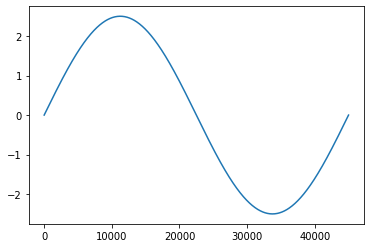

In [6]:
wlev_dif = [np.linspace(0,45000,1000),np.zeros(1000)]
for i in range(len(wlev_dif[0])):
    wlev_dif[1][i] = 2.5*math.sin(2*math.pi*wlev_dif[0][i]/(45000))
    
plt.plot(wlev_dif[0],wlev_dif[1])

In [7]:
waiting_area_1 = corelock.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 6")

lineup_area_1 = corelock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = 'Volkeraksluizen_1', node = "Node 8", lineup_length = 300)

lock_1 = corelock.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',            
                         node_1 = "Node 10", node_2 = "Node 11", node_3 = "Node 12",
                         lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                         doors_open = 10 * 60, doors_close = 10 * 60, wlev_dif = wlev_dif, disch_coeff = 0.8,
                         grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                         simulation_start = simulation_start, operating_time = 25*60)
                                      
waiting_area_2 = corelock.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = "Volkeraksluizen_1", node = "Node 16")

lineup_area_2 = corelock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = "Volkeraksluizen_1", node = "Node 14", lineup_length = 300)

In [8]:
#For testing, all locks have the water level at the right side
lock_1.water_level = "Node 10"
FG.nodes["Node 11"]["Lock"] = [lock_1]

FG.nodes["Node 6"]["Waiting area"] = [waiting_area_1]
FG.nodes["Node 8"]["Line-up area"] = [lineup_area_1]

FG.nodes["Node 16"]["Waiting area"] = [waiting_area_2]
FG.nodes["Node 14"]["Line-up area"] = [lineup_area_2] 

In [9]:
for vessel in vessels:
    vessel.env = env
    env.process(vessel.move())

In [10]:
env.FG = FG
env.run()

In [11]:
df = pd.DataFrame.from_dict(vessels[6].log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 21 to node Node 20 start,2021-05-25 10:47:26.000000,0.000000,POINT (4.385381824047309 51.67609098108045)
1,Sailing from node Node 21 to node Node 20 stop,2021-05-25 10:48:18.806445,0.000000,POINT (4.387028491268927 51.6776897747193)
2,Sailing from node Node 20 to node Node 19 start,2021-05-25 10:48:18.806445,0.000000,POINT (4.387028491268927 51.6776897747193)
3,Sailing from node Node 20 to node Node 19 stop,2021-05-25 10:48:56.956651,0.000000,POINT (4.388336842048544 51.67879411774161)
4,Sailing from node Node 19 to node Node 18 start,2021-05-25 10:48:56.956651,0.000000,POINT (4.388336842048544 51.67879411774161)
5,Sailing from node Node 19 to node Node 18 stop,2021-05-25 10:49:46.074315,0.000000,POINT (4.390189828820366 51.68013249657422)
6,Sailing from node Node 18 to node Node 17 start,2021-05-25 10:49:46.074315,0.000000,POINT (4.390189828820366 51.68013249657422)
7,Sailing from node Node 18 to node Node 17 stop,2021-05-25 10:50:54.680394,0.000000,POINT (4.393109213885338 51.68180281425153)
8,Sailing from node Node 17 to node Node 16 start,2021-05-25 10:50:54.680394,0.000000,POINT (4.393109213885338 51.68180281425153)
9,Sailing from node Node 17 to node Node 16 stop,2021-05-25 10:52:19.663567,0.000000,POINT (4.396838866281541 51.68379266841475)


In [12]:
locking_cycle_start_dir1 = simulation_start.timestamp()
locking_cycle_starts_dir1 = []
locking_cycle_stop_dir1 = simulation_start.timestamp()
locking_cycle_stops_dir1 = []
locking_cycle_start_dir2 = simulation_start.timestamp()
locking_cycle_starts_dir2 = []
locking_cycle_stop_dir2 = simulation_start.timestamp()
locking_cycle_stops_dir2 = []

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].route[0] == 'Node 1':
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir1 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir1:
                    pass
                else:
                    locking_cycle_start_dir1 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir1.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir1 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir1 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir1 and vessels[v2].route[0] == 'Node 1':                               
                                    if len(locking_cycle_starts_dir1) != len(locking_cycle_stops_dir1):
                                        locking_cycle_stops_dir1.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir1[-1][0]:
                                        locking_cycle_stops_dir1[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

        elif vessels[v].route[0] == 'Node 21': 
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir2 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir2:
                    pass
                else:
                    locking_cycle_start_dir2 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir2.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir2 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir2 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir2 and vessels[v2].route[0] == 'Node 21':                               
                                    if len(locking_cycle_starts_dir2) != len(locking_cycle_stops_dir2):
                                        locking_cycle_stops_dir2.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir2[-1][0]:
                                        locking_cycle_stops_dir2[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

inoperation_time_doors1 = locking_cycle_starts_dir2+locking_cycle_stops_dir1
inoperation_time_doors1.sort()
inoperation_time_doors2 = locking_cycle_starts_dir1+locking_cycle_stops_dir2
inoperation_time_doors2.sort()
loop_time_doors1 = []
loop_time_doors2 = []

for i in range(len(inoperation_time_doors1)):
    if i != 0 and inoperation_time_doors1[i][1] == 'Start' and inoperation_time_doors1[i-1][1] != 'Start':
        loop_time_doors1.append((inoperation_time_doors1[i][0]-inoperation_time_doors1[i-1][0])/60)
        
for i in range(len(inoperation_time_doors2)):
    if i != 0 and inoperation_time_doors2[i][1] == 'Start' and inoperation_time_doors2[i-1][1] != 'Start':
        loop_time_doors2.append((inoperation_time_doors2[i][0]-inoperation_time_doors2[i-1][0])/60)

In [13]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
waiting_in_lock = []
total_waiting_time = np.zeros(len(vessels))

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Passing lock stop":
            waiting_in_lock.append(vessels[v].log["Value"][t]/60)
            
for v in range(len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
            total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))

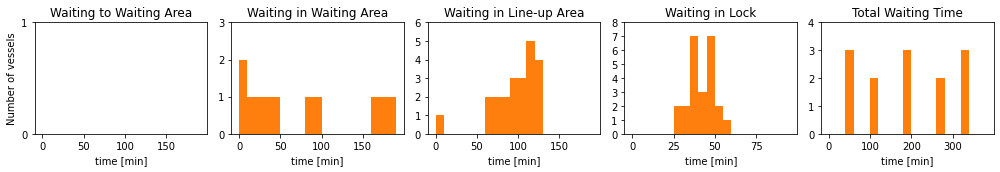

In [14]:
data= [waiting_to_waiting_area,waiting_in_waiting_area,waiting_in_lineup_area,waiting_in_lock,total_waiting_time]
xaxes = 'time [min]'
titles = ['Waiting to Waiting Area','Waiting in Waiting Area','Waiting in Line-up Area','Waiting in Lock','Total Waiting Time'] 
bins = [range(0,200,10),range(0,200,10),range(0,200,10),range(0,100,5),range(0,400,20)]

f,a = plt.subplots(1,5,figsize=(14, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Number of vessels')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

In [15]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []
origin = 'Node 1'
destination = 'Node 21'

for v in range(0,len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0,len(vessels[v].log["Message"])):
        if vessels[v].route[0] == 'Node 1':   
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
        if vessels[v].route[0] == 'Node 21':     
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance((env.FG.nodes[destination]['geometry'].x,env.FG.nodes[destination]['geometry'].y),(env.FG.nodes[origin]['geometry'].x,env.FG.nodes[origin]['geometry'].y))-
                                  calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

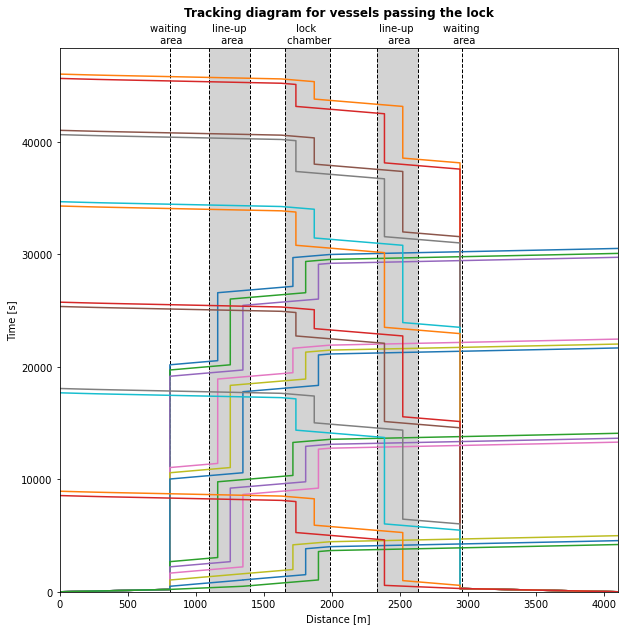

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
for v in reversed(range(0,len(vessels))):
    plt.plot(vessel_path_x[v],vessel_path_t[v])

plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'lock \n chamber',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))-
         0.5*calculate_distance((FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y),(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y))+
         0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')

plt.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
plt.xlabel("Distance [m]")
plt.xlim([0,0.95*ax.get_xlim()[1]])
plt.ylim([0,ax.get_ylim()[1]])
plt.ylabel("Time [s]")

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.show()

In [17]:
df = pd.DataFrame.from_dict(lock_1.log)
df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2021-05-25 11:20:24.682735,3,Node 10
1,Lock doors closing stop,2021-05-25 11:30:24.682735,3,Node 10
2,Lock chamber converting start,2021-05-25 11:30:24.682735,3,Node 10
3,Lock chamber converting stop,2021-05-25 11:37:03.215763,3,Node 12
4,Lock doors opening start,2021-05-25 11:37:03.215763,3,Node 12
...,...,...,...,...
67,Lock doors closing stop,2021-05-25 23:07:04.018011,2,Node 12
68,Lock chamber converting start,2021-05-25 23:07:04.018011,2,Node 12
69,Lock chamber converting stop,2021-05-25 23:08:43.902738,2,Node 10
70,Lock doors opening start,2021-05-25 23:08:43.902738,2,Node 10


In [18]:
door_open_time_doors_1 = []
door_open_time_doors_2 = []
end_time = []
for v in range(0,len(vessels)):
    end_time.append(vessels[v].log["Timestamp"][-1].timestamp())
end_of_simulation = max(end_time)

for l in range(0,len(env.FG.nodes['Node 11']['Lock'])):
    for t in range(0,len(env.FG.nodes['Node 11']['Lock'][l].log["Message"])-1):
        if env.FG.nodes['Node 11']['Lock'][l].log["Message"][t] == "Lock doors closing stop" and env.FG.nodes['Node 11']['Lock'][l].log["Geometry"][t] == 'Node 10':
            for t2 in reversed(range(0,t)):
                if env.FG.nodes['Node 11']['Lock'][l].log["Message"][t2] == "Lock doors opening start":
                    door_open_time_doors_1.append(env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                                  env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t2].timestamp()/60)
                    break
            else:
                door_open_time_doors_1.append(env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                              simulation_start.timestamp()/60)
        elif env.FG.nodes['Node 11']['Lock'][l].log["Message"][t] == "Lock doors closing stop" and env.FG.nodes['Node 11']['Lock'][l].log["Geometry"][t] == 'Node 12':
            for t2 in reversed(range(0,t)):
                if env.FG.nodes['Node 11']['Lock'][l].log["Message"][t2] == "Lock doors opening start":
                    door_open_time_doors_2.append(env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                                  env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t2].timestamp()/60)
                    break
            else:
                door_open_time_doors_2.append(env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                              simulation_start.timestamp()/60)

for l in range(0,len(env.FG.nodes['Node 11']['Lock'])):
    for t in reversed(range(0,len(env.FG.nodes['Node 11']['Lock'][l].log["Message"]))):
        if env.FG.nodes['Node 11']['Lock'][l].log["Message"][t] == "Lock doors opening stop" and env.FG.nodes['Node 11']['Lock'][l].log["Geometry"][t] == 'Node 10':          
            for t2 in range(t,len(env.FG.nodes['Node 11']['Lock'][l].log["Message"])):
                if env.FG.nodes['Node 11']['Lock'][l].log["Message"][t2] == "Lock doors closing stop":
                    pass
            else:
                door_open_time_doors_1.append(end_of_simulation/60-
                                              env.FG.nodes['Node 11']['Lock'][l].log["Timestamp"][t].timestamp()/60)
                break


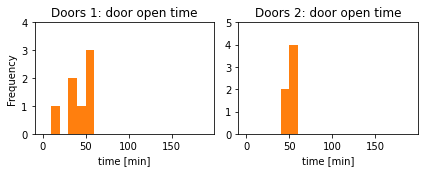

In [19]:
data= [door_open_time_doors_1,door_open_time_doors_2]
xaxes = 'time [min]'
titles = ['Doors 1: door open time','Doors 2: door open time'] 
bins = [range(0,200,10),range(0,200,10)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

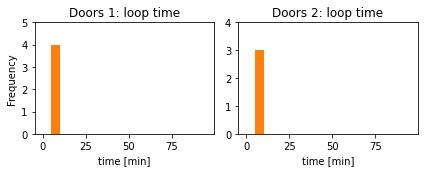

In [20]:
data= [loop_time_doors1,loop_time_doors2]
xaxes = 'time [min]'
titles = ['Doors 1: loop time','Doors 2: loop time'] 
bins = [range(0,100,5),range(0,100,5)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()